In [26]:
import glob  
import os  
import librosa  
import numpy as np  
from keras.models import Sequential  
from keras.layers import Dense, Activation  
from keras.layers import Dropout  
from sklearn.model_selection import train_test_split  
from sklearn.metrics import confusion_matrix, accuracy_score
import pandas as pd  
import seaborn as sns  
import matplotlib.pyplot as plt
from tqdm import tqdm

In [91]:
def extract_feature(file_name, n_fft, hop): 
    X, sample_rate = librosa.load(file_name)
    stft = np.abs(librosa.stft(X))
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate, n_fft=n_fft, hop_length=hop).T,axis=0)
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate, n_fft=n_fft, hop_length=hop).T,axis=0)
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate, n_fft=n_fft, hop_length=hop).T,axis=0)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0)
    return mfccs,chroma,mel,contrast,tonnetz

def parse_audio_files(parent_dir,sub_dirs,file_ext="*.wav", n_fft=2048, hop=512):
    features, labels = np.empty((0,193)), np.empty(0)
    for label, sub_dir in enumerate(tqdm(sub_dirs)):
        for fn in glob.glob(os.path.join(parent_dir, sub_dir, file_ext)):
            try:
                mfccs, chroma, mel, contrast,tonnetz = extract_feature(fn, n_fft=n_fft, hop=hop)
            except Exception as e:
                print ("Error encountered while parsing file: ", fn)
                continue
            ext_features = np.hstack([mfccs,chroma,mel,contrast,tonnetz])
            features = np.vstack([features,ext_features])
            labels = np.append(labels, fn.split('/')[3].split('-')[2])
    return np.array(features), np.array(labels, dtype = np.int)

def one_hot_encode(labels):
    n_labels = len(labels)
    n_unique_labels = len(np.unique(labels))
    one_hot_encode = np.zeros((n_labels,n_unique_labels+1))
    one_hot_encode[np.arange(n_labels), labels] = 1
    one_hot_encode=np.delete(one_hot_encode, 0, axis=1)
    return one_hot_encode

In [30]:
#change the main_dir acordingly....  
main_dir = './data'  
sub_dir=os.listdir(main_dir)  
print ("\ncollecting features and labels...")  
print("\nthis will take some time...")  
features, labels = parse_audio_files(main_dir,sub_dir)  
print("done")  
np.save('X',features)  
#one hot encoding labels  
labels = one_hot_encode(labels)
np.save('y', labels)

  0%|          | 0/24 [00:00<?, ?it/s]


collecting features and labels...

this will take some time...


 12%|█▎        | 3/24 [02:58<20:44, 59.25s/it]/home/hj/anaconda3/envs/pytorch/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=1012
  warnings.warn(
100%|██████████| 24/24 [24:05<00:00, 60.21s/it]

done



<ipython-input-29-89a105739759>:23: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.array(features), np.array(labels, dtype = np.int)


In [59]:
X=np.load('X.npy')  
y=np.load('y.npy')  
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.33, random_state=42)

In [63]:
#dnn parameters
n_dim = train_x.shape[1]  
n_classes = train_y.shape[1]  
n_hidden_units_1 = n_dim  
n_hidden_units_2 = 400 # approx n_dim * 2  
n_hidden_units_3 = 200 # half of layer 2  
n_hidden_units_4 = 100

#defining the model
def create_model(activation_function='relu', init_type='normal', optimiser='adam', dropout_rate=0.2):
    model = Sequential()
    # layer 1
    model.add(Dense(n_hidden_units_1, input_dim=n_dim, activation=activation_function))
    # layer 2
    model.add(Dense(n_hidden_units_2, activation=activation_function))
    model.add(Dropout(dropout_rate))
    # layer 3
    model.add(Dense(n_hidden_units_3, activation=activation_function))
    model.add(Dropout(dropout_rate))
    #layer4
    model.add(Dense(n_hidden_units_4, activation=activation_function))
    model.add(Dropout(dropout_rate))
    # output layer
    model.add(Dense(n_classes, activation='softmax'))
    #model compilation
    model.compile(loss='categorical_crossentropy', optimizer=optimiser, metrics=['accuracy'])
    return model

In [64]:
#create the model  
model = create_model()  
#train the model  
history = model.fit(train_x, train_y, epochs=200, batch_size=4)

Epoch 1/200
241/241 [==============================] - 1s 3ms/step - loss: 5.2905 - accuracy: 0.1058
Epoch 2/200
241/241 [==============================] - 1s 3ms/step - loss: 2.1610 - accuracy: 0.1639
Epoch 3/200
241/241 [==============================] - 1s 3ms/step - loss: 2.0831 - accuracy: 0.1784
Epoch 4/200
241/241 [==============================] - 1s 3ms/step - loss: 2.0567 - accuracy: 0.1701
Epoch 5/200
241/241 [==============================] - 1s 3ms/step - loss: 2.0343 - accuracy: 0.1691
Epoch 6/200
241/241 [==============================] - 1s 3ms/step - loss: 2.0027 - accuracy: 0.2012
Epoch 7/200
241/241 [==============================] - 1s 3ms/step - loss: 2.0395 - accuracy: 0.1857
Epoch 8/200
241/241 [==============================] - 1s 3ms/step - loss: 1.9826 - accuracy: 0.2054
Epoch 9/200
241/241 [==============================] - 1s 3ms/step - loss: 1.9499 - accuracy: 0.2199
Epoch 10/200
241/241 [==============================] - 1s 3ms/step - loss: 1.9601 - accura

241/241 [==============================] - 1s 3ms/step - loss: 0.7729 - accuracy: 0.7230
Epoch 82/200
241/241 [==============================] - 1s 2ms/step - loss: 0.7704 - accuracy: 0.7075
Epoch 83/200
241/241 [==============================] - 1s 3ms/step - loss: 0.7415 - accuracy: 0.7427
Epoch 84/200
241/241 [==============================] - 1s 3ms/step - loss: 0.9360 - accuracy: 0.6805
Epoch 85/200
241/241 [==============================] - 1s 3ms/step - loss: 0.7248 - accuracy: 0.7251
Epoch 86/200
241/241 [==============================] - 1s 3ms/step - loss: 0.6835 - accuracy: 0.7573
Epoch 87/200
241/241 [==============================] - 1s 3ms/step - loss: 0.6421 - accuracy: 0.7624
Epoch 88/200
241/241 [==============================] - 1s 3ms/step - loss: 0.6349 - accuracy: 0.7593
Epoch 89/200
241/241 [==============================] - 1s 3ms/step - loss: 0.6452 - accuracy: 0.7583
Epoch 90/200
241/241 [==============================] - 1s 2ms/step - loss: 0.6568 - accuracy: 

241/241 [==============================] - 1s 3ms/step - loss: 0.2572 - accuracy: 0.9066
Epoch 161/200
241/241 [==============================] - 1s 3ms/step - loss: 0.5520 - accuracy: 0.8382
Epoch 162/200
241/241 [==============================] - 1s 3ms/step - loss: 0.4100 - accuracy: 0.8683
Epoch 163/200
241/241 [==============================] - 1s 3ms/step - loss: 0.3084 - accuracy: 0.8900
Epoch 164/200
241/241 [==============================] - 1s 3ms/step - loss: 0.3600 - accuracy: 0.8869
Epoch 165/200
241/241 [==============================] - 1s 3ms/step - loss: 0.3751 - accuracy: 0.8724
Epoch 166/200
241/241 [==============================] - 1s 3ms/step - loss: 0.6482 - accuracy: 0.8475
Epoch 167/200
241/241 [==============================] - 1s 3ms/step - loss: 0.3196 - accuracy: 0.8880
Epoch 168/200
241/241 [==============================] - 1s 3ms/step - loss: 0.3191 - accuracy: 0.8994
Epoch 169/200
241/241 [==============================] - 1s 3ms/step - loss: 0.3362 - a

In [74]:
#predicting from the model  
predict=model.predict(test_x,batch_size=4)

emotions=['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']  
#predicted emotions from the test set  
y_pred = np.argmax(predict, 1)  
predicted_emo=[]   
for i in range(0,test_y.shape[0]):  
    emo=emotions[y_pred[i]]  
    predicted_emo.append(emo)
    
actual_emo=[]  
y_true=np.argmax(test_y, 1)  
for i in range(0,test_y.shape[0]):  
    emo=emotions[y_true[i]]  
    actual_emo.append(emo)

<AxesSubplot:>

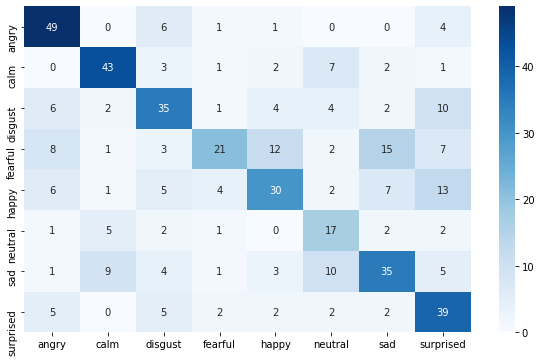

In [75]:
#generate the confusion matrix  
cm =confusion_matrix(actual_emo, predicted_emo)  
index = ['angry', 'calm', 'disgust', 'fearful', 'happy', 'neutral', 'sad', 'surprised']  
columns = ['angry', 'calm', 'disgust', 'fearful', 'happy', 'neutral', 'sad', 'surprised']  
cm_df = pd.DataFrame(cm,index,columns)                      
plt.figure(figsize=(10,6))  
sns.heatmap(cm_df, annot=True, cmap="Blues")  

In [78]:
accuracy_score(actual_emo, predicted_emo)

0.5651260504201681

In [93]:
#change the main_dir acordingly....  
main_dir = './data'  
sub_dir=os.listdir(main_dir)  
print ("\ncollecting features and labels...")  
print("\nthis will take some time...")  
features, labels = parse_audio_files(main_dir,sub_dir, n_fft=512, hop=128)  
print("done")
#one hot encoding labels  
labels = one_hot_encode(labels)
np.savez("xy", features, labels)

  0%|          | 0/24 [00:00<?, ?it/s]


collecting features and labels...

this will take some time...


 12%|█▎        | 3/24 [02:52<20:05, 57.38s/it]/home/hj/anaconda3/envs/pytorch/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=1012
  warnings.warn(
100%|██████████| 24/24 [23:39<00:00, 59.16s/it]

done



<ipython-input-91-805e445fa969>:23: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.array(features), np.array(labels, dtype = np.int)


TypeError: 'tuple' object is not callable

In [102]:
X=np.load('X_512.npy')  
y=np.load('y_512.npy')  
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.33, random_state=42)

#create the model  
model = create_model()  
#train the model  
history = model.fit(train_x, train_y, epochs=200, batch_size=4)

Epoch 1/200
241/241 [==============================] - 1s 3ms/step - loss: 5.3214 - accuracy: 0.1369
Epoch 2/200
241/241 [==============================] - 1s 4ms/step - loss: 2.2018 - accuracy: 0.1515
Epoch 3/200
241/241 [==============================] - 1s 3ms/step - loss: 2.0908 - accuracy: 0.1598
Epoch 4/200
241/241 [==============================] - 1s 3ms/step - loss: 2.0044 - accuracy: 0.1981
Epoch 5/200
241/241 [==============================] - 1s 3ms/step - loss: 1.9713 - accuracy: 0.2251
Epoch 6/200
241/241 [==============================] - 1s 3ms/step - loss: 1.9466 - accuracy: 0.2106
Epoch 7/200
241/241 [==============================] - 1s 3ms/step - loss: 1.9608 - accuracy: 0.1971
Epoch 8/200
241/241 [==============================] - 1s 3ms/step - loss: 1.9121 - accuracy: 0.2324
Epoch 9/200
241/241 [==============================] - 1s 3ms/step - loss: 1.8789 - accuracy: 0.2604
Epoch 10/200
241/241 [==============================] - 1s 3ms/step - loss: 1.8488 - accura

241/241 [==============================] - 1s 3ms/step - loss: 0.6816 - accuracy: 0.7365
Epoch 82/200
241/241 [==============================] - 1s 3ms/step - loss: 0.7301 - accuracy: 0.7396
Epoch 83/200
241/241 [==============================] - 1s 3ms/step - loss: 0.7258 - accuracy: 0.7220
Epoch 84/200
241/241 [==============================] - 1s 3ms/step - loss: 0.6254 - accuracy: 0.7687
Epoch 85/200
241/241 [==============================] - 1s 4ms/step - loss: 0.7038 - accuracy: 0.7344
Epoch 86/200
241/241 [==============================] - 1s 5ms/step - loss: 0.6581 - accuracy: 0.7490
Epoch 87/200
241/241 [==============================] - 1s 3ms/step - loss: 0.6427 - accuracy: 0.7583
Epoch 88/200
241/241 [==============================] - 1s 3ms/step - loss: 0.6231 - accuracy: 0.7604
Epoch 89/200
241/241 [==============================] - 1s 3ms/step - loss: 0.6322 - accuracy: 0.7614
Epoch 90/200
241/241 [==============================] - 1s 3ms/step - loss: 0.5921 - accuracy: 

241/241 [==============================] - 1s 3ms/step - loss: 0.4525 - accuracy: 0.8568
Epoch 161/200
241/241 [==============================] - 1s 3ms/step - loss: 0.3119 - accuracy: 0.8900
Epoch 162/200
241/241 [==============================] - 1s 3ms/step - loss: 0.2357 - accuracy: 0.9336
Epoch 163/200
241/241 [==============================] - 1s 3ms/step - loss: 0.5295 - accuracy: 0.8465
Epoch 164/200
241/241 [==============================] - 1s 3ms/step - loss: 0.3961 - accuracy: 0.8755
Epoch 165/200
241/241 [==============================] - 1s 3ms/step - loss: 0.3052 - accuracy: 0.9056
Epoch 166/200
241/241 [==============================] - 1s 3ms/step - loss: 0.2718 - accuracy: 0.9025
Epoch 167/200
241/241 [==============================] - 1s 3ms/step - loss: 0.4056 - accuracy: 0.8703
Epoch 168/200
241/241 [==============================] - 1s 3ms/step - loss: 0.4487 - accuracy: 0.8496
Epoch 169/200
241/241 [==============================] - 1s 3ms/step - loss: 0.2588 - a

Acc:  0.6092436974789915


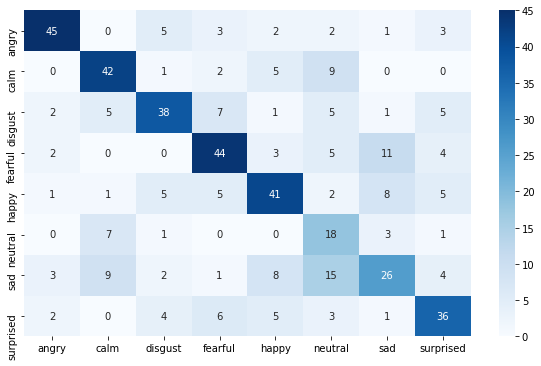

In [105]:
#predicting from the model  
predict=model.predict(test_x, batch_size=4)

emotions=['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']  
#predicted emotions from the test set  
y_pred = np.argmax(predict, 1)  
predicted_emo=[]   
for i in range(0,test_y.shape[0]):  
    emo=emotions[y_pred[i]]  
    predicted_emo.append(emo)
    
actual_emo=[]  
y_true=np.argmax(test_y, 1)  
for i in range(0,test_y.shape[0]):  
    emo=emotions[y_true[i]]  
    actual_emo.append(emo)

    
print("Acc: ", accuracy_score(actual_emo, predicted_emo))
#generate the confusion matrix  
cm =confusion_matrix(actual_emo, predicted_emo)  
index = ['angry', 'calm', 'disgust', 'fearful', 'happy', 'neutral', 'sad', 'surprised']  
columns = ['angry', 'calm', 'disgust', 'fearful', 'happy', 'neutral', 'sad', 'surprised']  
cm_df = pd.DataFrame(cm,index,columns)                      
plt.figure(figsize=(10,6))  
sns.heatmap(cm_df, annot=True, cmap="Blues"); 

In [119]:
290/476

0.6092436974789915

In [120]:
tonnetz

array([-0.02840879,  0.04684916,  0.0140578 ,  0.07203509,  0.00926491,
        0.00067316])